## Homework №3: Review classification 
*Bezhenaer OLga*

In [1]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn import grid_search
import matplotlib.pyplot as plt

/home/st039712/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/st039712/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

### EDA

In [3]:
#data loading 
df_train = pd.read_csv("train.tsv", sep="\t")
df_test = pd.read_csv("test.tsv", sep="\t")
df_sub=pd.read_csv("sampleSubmission.csv")

In [4]:
df_train.head(10)

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
5,6,1,of escapades demonstrating the adage that what...,2
6,7,1,of,2
7,8,1,escapades demonstrating the adage that what is...,2
8,9,1,escapades,2
9,10,1,demonstrating the adage that what is good for ...,2


In [5]:
df_test.head(10)

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine
5,156066,8545,intermittently pleasing but
6,156067,8545,intermittently pleasing
7,156068,8545,intermittently
8,156069,8545,pleasing
9,156070,8545,but


In [6]:
df_sub.tail(10)

,PhraseId,Sentiment
66282,222343,2
66283,222344,2
66284,222345,2
66285,222346,2
66286,222347,2
66287,222348,2
66288,222349,2
66289,222350,2
66290,222351,2
66291,222352,2


In [7]:
#data visualization
dist = df_train.groupby(["Sentiment"]).size()
dist = dist / dist.sum()
fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(dist.keys(), dist.values);

In [8]:
df_train['Sentiment'].value_counts() #sample imbalance

2    79582
3    32927
1    27273
4     9206
0     7072
Name: Sentiment, dtype: int64

### Text preprosessing 

In [9]:
#check for any empty Phrases
df_train= df_train[df_train['Phrase'].str.len() >0]

In [10]:
#are there any empty Phrases? if so let's remove them
df_train[df_train['Phrase'].str.len() == 0].head()

,PhraseId,SentenceId,Phrase,Sentiment


In [11]:
df_train = df_train[df_train['Phrase'].str.len() != 0]

In [12]:
df_train[df_train['Phrase'].str.len() == 0].head()

,PhraseId,SentenceId,Phrase,Sentiment


In [13]:
#converting to the lower case 
df_train['Phrase'] = df_train['Phrase'].map(lambda x: x.lower())  

In [14]:
#removing punctuation
df_train['Phrase'] = df_train['Phrase'].str.replace('[^\w\s]', '') 

In [15]:
#removing digits
df_train['Phrase'] = df_train['Phrase'].str.replace('[0-9]', '')

In [16]:
#function to reove stopwords
def text_process(mess): 
  
    nostopwords = [word for word in mess.split() if word.lower() not in stopwords.words('english')]
    
    # Join the characters again to form the string.
    nostopwords = ' '.join(nostopwords)
    
    return nostopwords

In [17]:
#Over-samplig of the minority classes - solving the prolblem of sample imbalance
sent_2 = df_train[df_train['Sentiment']==2]
#we will copy class 0 11 times
sent_0 = df_train[df_train['Sentiment']==0]
#we will copy class 1 2 times
sent_1 = df_train[df_train['Sentiment']==1]
#we will copy class 3 2 times
sent_3 = df_train[df_train['Sentiment']==3]
#we will copy class 4 8 times
sent_4 = df_train[df_train['Sentiment']==4]

#-----------------------------------------------------
df_train = df_train.append([sent_0,sent_0,sent_0,sent_0,sent_0,sent_0,sent_0,sent_0,sent_0,sent_0])
df_train = df_train.append([sent_1,sent_1])
df_train = df_train.append([sent_3])
df_train = df_train.append([sent_4,sent_4,sent_4,sent_4,sent_4,sent_4,sent_4])

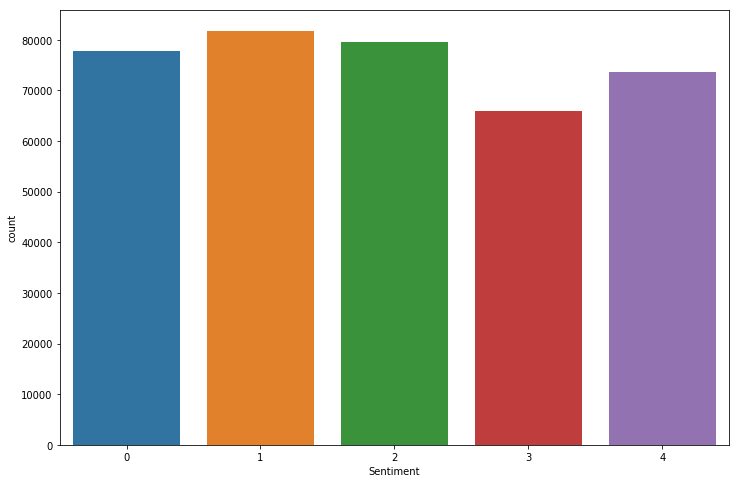

In [18]:
#checking the resuts of "balancing"
sns.countplot(data=df_train,x='Sentiment')
plt.show()

In [19]:
from sklearn.model_selection import train_test_split

In [20]:
# train data split 

X = df_train['Phrase']
y = df_train['Sentiment']
msg_train,msg_test,label_train,label_test = train_test_split(X,y)

In [21]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report

In [26]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/st039712/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [27]:
# the RandomForestClassifier model to predict

pipelineRFC = Pipeline([
    ('bow',CountVectorizer(analyzer=text_process)),
    ('tfidf',TfidfTransformer()),
    ('classifier',RandomForestClassifier(n_estimators=5))
])

In [58]:
pipelineRFC.fit(msg_train,label_train)
preds = pipelineRFC.predict(msg_test)
print(classification_report(label_test,preds))

             precision    recall  f1-score   support

          0       0.87      0.98      0.92     19556
          1       0.78      0.78      0.78     20412
          2       0.75      0.64      0.69     20170
          3       0.73      0.64      0.68     16270
          4       0.86      0.97      0.91     18266

avg / total       0.80      0.80      0.80     94674



### Quality metric: again f1
As it was mentioned above, the problem of sample imbalance is presented in our data. In that case the "accuracy" score does not show trustworthy results. The main metrics for quality might be recalls, precision and f1-score. What is important for us? 
 - Equiality of recall_1 and recall_0 (meaning that classifier predicts well both positive and negative classes) the close recall_1 and recall_0 too each other - the better quality of the classifier;
 - F1-score - it comprises both precision and recall metrics and does not suffer as "accuracy" metric from sample imbalance.

### Prediction 

In [59]:
#storing predictions as a varialbe 
preds = pipelineRFC.predict(df_test['Phrase'])

In [60]:
sub = pd.DataFrame(columns=['PhraseId','Sentiment'])
sub['PhraseId'] = df_test['PhraseId']
sub['Sentiment'] = pd.Series(preds)

In [61]:
sub.head()

,PhraseId,Sentiment
0,156061,1
1,156062,1
2,156063,2
3,156064,1
4,156065,1


In [63]:
sub['Sentiment'].value_counts()

2    32235
1    15494
3    12266
0     3173
4     3124
Name: Sentiment, dtype: int64

In [62]:
sns.countplot(data=sub,x='Sentiment')

### Comparison: word-embeddings vs classical methods

Word Embeddings methods could capture more close to the human thinking patterns, like sarcas/irony. While the results of predictions of classical models are much lower in the case of semantic analysis